# Math 607 HW 4
### Sean Ericson 6/10/2024

In [1]:
# Imports
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
mpl.rcParams["animation.html"] = "jshtml"

%matplotlib inline

## Ising Model

### a)
Each state is just a given arrangement of the spins. To make a move we select a random site to flip. We calculate the change in energy $\Delta H$ resulting from making that flip, and with probability $\text{min}(1, e^{-\beta \Delta H})$ we keep the move.

### b)

In [16]:
# Code
def neighbor_indices(n, i, j):
    """
    For an n x n grid return the neighbors [(i, j+1), (i+1, j), ...] for the point (i,j)
    """
    return [(i+x, j+y) for x,y in [(0,1), (0, -1), (1, 0), (-1, 0)] if 0 <= i+x <= n-1 and 0 <= j+y <= n-1]

def neighbor_spins(σ, i, j):
    '''
    For the given set of spins, return the list of spins neighboring position (i,j)
    '''
    n = σ.shape[0]
    return [σ[x, y] for x,y in neighbor_indices(n, i, j)]

def Ising_Hamiltonian(σ, J, μ):
    """
    For the given spins, spin coupling, and magnetic field strength, return the total energy of the spins
    """
    n = σ.shape[0]
    return -J*sum([(σ[i, j]*σ[i, j+1] if j < n-1 else 0) + (σ[i, j]*σ[i+1, j] if i < n-1 else 0) for i in range(n) for j in range(n)]) -μ*σ.sum()

def comparable(σ1, σ2):
    """
    Determine if two spins are comparable under the natural partial order
    """
    return (σ1 <= σ2).all() or (σ1 > σ2).all()

def set_spin(σ, J, μ, β, site, state):
    """
    With probability min(1, ΔH) flip the spin at the given site
    """
    i, j = site
    
    # Sum neighbor spins
    neb_sum = sum(neighbor_spins(σ, i, j))
    
    # Calculate the change in energy
    ΔH = -2*state*(J*neb_sum + μ)

    if np.random.rand() <= min(1, np.exp(-β*ΔH)):
        σ[i,j] = state
        return True
    
    return False

def plot_spins(σ, ax, energy=None):
    ax.axis('off')
    ax.imshow(σ, cmap="Greys", vmin=-1, vmax=1)
    if energy is not None:
        ax.set_title("$H = {}$".format(energy))

In [17]:
def sample_spins(N, J, μ, β):
    # Initialize maximal/minimal elements of the poset.
    high = np.ones((N,N))
    low = -1*np.ones((N,N))
    random = np.random.randint(2, size=(N,N))*2 - 1

    # Initialize lists to track states
    lows = [np.array(low)]
    highs = [np.array(high)]

    # Loop until the min/max elements become equal
    while not np.array_equal(low, high):
        # Pick a random site
        i, j = np.random.randint(N, size=2)
        state = -random[i, j]

        if not set_spin(random, J, μ, β, (i, j), state):
            continue

        # Set the same spin on each state
        low[i, j] = state
        high[i, j] = state

        # Record states
        lows.append(np.array(low))
        highs.append(np.array(high))

        if not comparable(low, high):
            raise Exception("ahh")
    
    return low, lows, highs

The code below samples the distribution of spins with $J = 1$, $\mu = 1$, $\beta = 0.1$

In [18]:
# Define sim constants
N = 20
J, μ, β = (1, 1, .1)

sample, lows, highs = sample_spins(N, J, μ, β)
num_iter = len(lows)
final_energy = Ising_Hamiltonian(sample, J, μ)

print("Number of iterations: ", num_iter)

Number of iterations:  2890


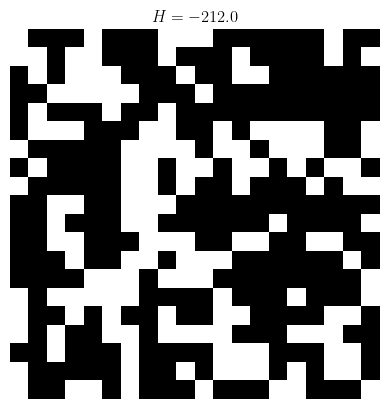

In [19]:
fig, ax = plt.subplots()
plot_spins(sample, ax, final_energy)
plt.show()

In [243]:
xs = list(range(num_iter))
low_Hs = [Ising_Hamiltonian(σ, J, μ) for σ in lows]
high_Hs = [Ising_Hamiltonian(σ, J, μ) for σ in highs]

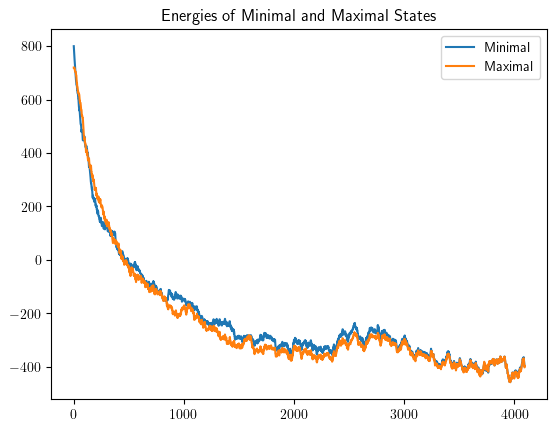

In [244]:
plt.plot(xs, low_Hs, label="Minimal")
plt.plot(xs, high_Hs, label="Maximal")
plt.title("Energies of Minimal and Maximal States")
plt.legend()
plt.show()

In [245]:
# fig, ax = plt.subplots(1, 2)
# def update(frame):
#     plt.cla()
#     plot_spins(lows[frame], ax[0])
#     plot_spins(highs[frame], ax[1])
#     ax[0].set_title("$H = {}$".format(Ising_Hamiltonian(lows[0], J, μ)))
#     ax[1].set_title("$H = {}$".format(Ising_Hamiltonian(highs[0], J, μ)))
    
# anim = animation.FuncAnimation(fig, update, len(lows), interval=20)
# plt.close()
# display(anim)

### c)

In [21]:
def count_iterations(Ns, samples_per_N, param):
    sample_iters = []
    for N in Ns:
        sample_iters.append([])
        for _ in range(samples_per_N):
            _, lows, _ = sample_spins(N, *param)
            sample_iters[-1].append(len(lows))
    return sample_iters

In [22]:
param = (1, 1, .01)
N_max = 20
samples_per_N = 50
Ns = list(range(2, 20))
iter_counts = count_iterations(Ns, samples_per_N, param)

The code below plots the average number of iterations needed to converge for a couple different parameter settings. In both cases, the complexity appears to be quadratic. Lower temperature/field-strength rations do tend to have hight coefficients for the $n^2$ term.

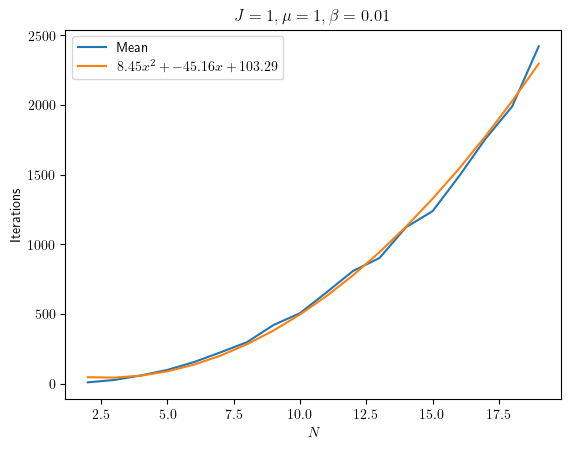

In [24]:
quad = lambda x, a, b, c: a*x*x + b*x + c

means = np.array(iter_counts).mean(axis=1)

fit_param, _ = scipy.optimize.curve_fit(quad, Ns, means)
fit = [quad(n, *fit_param) for n in Ns]

plt.plot(Ns, means, label="Mean")
plt.plot(Ns, fit, label="${:.2f}x^2 + {:.2f}x + {:.2f}$".format(*fit_param))
plt.title("$J = {}, \\mu = {}, \\beta = {}$".format(*param))
plt.xlabel("$N$")
plt.ylabel("Iterations")
plt.legend()
plt.show()

In [28]:
param = (1, 1, .25)
N_max = 20
samples_per_N = 50
Ns = list(range(2, 20))
iter_counts = count_iterations(Ns, samples_per_N, param)

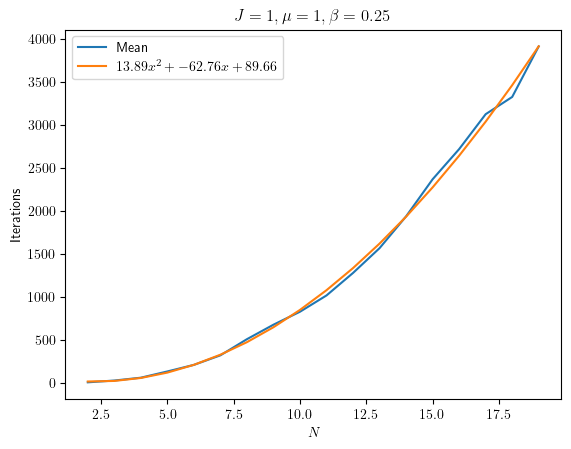

In [29]:
means = np.array(iter_counts).mean(axis=1)

fit_param, _ = scipy.optimize.curve_fit(quad, Ns, means)
fit = [quad(n, *fit_param) for n in Ns]

plt.plot(Ns, means, label="Mean")
plt.plot(Ns, fit, label="${:.2f}x^2 + {:.2f}x + {:.2f}$".format(*fit_param))
plt.title("$J = {}, \\mu = {}, \\beta = {}$".format(*param))
plt.xlabel("$N$")
plt.ylabel("Iterations")
plt.legend()
plt.show()

## Continuous time markov chains

### a)
The markov property
$$ \mathbb{P}(X_{l+1} = j \;|\; X_{l}=i, X_{l-1} = i_{l-1}, \ldots, X_0 = i_0) = \mathbb{P}(X_{t+1} = j\lvert X_{t}=i) $$
for discrete-time Markov chains already implies that
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0, \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t+s} = j \;|\; X_s = i), $$
i.e. it already gives us that the future is independent of the past, conditioned on the present. So, we just need to show that for a continuous-time Markov chain
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i). $$
Now, the probability $\mathbb{P}(X_{t+s} = j \;|\; X_s = i)$ depends on the number of transitions in the period $[s, s+t]$, $N([s, s+t])$. This number is distributed as
$$ \text{Poisson}(\mu([s, s+t])) = \text{Poisson}(\lambda(s+t-s)) = \text{Poisson}(\lambda t), $$
and clearly depends only on the length of the interval. Therefore,
$$ \mathbb{P}(X_{t+s} = j \;|\; X_s = i) = \mathbb{P}(X_{t} = j \;|\; X_0 = i), $$ 
and thus
$$ 
\mathbb{P}(X_{t+s} = j \;|\; X_s = i, X_{s_0} = i_0,  \ldots X_{s_n} = i_n) = \mathbb{P}(X_{t} = j \;|\; X_0 = i).
$$


### b)
The transition probability $p_t(i,j)$ is the probability that we are in state $j$ at time $t$, given that we started in state $i$. This is given by the sum of the probabilities that $k$ jumps take us from $i$ to $j$, weighted by the probability that $k$ jumps occur in time $t$. I.e.
$$ p_t(i,j) = \sum_{k=0}^\infty p_k^t \bra{j}A^k\ket{i},  $$
where
$$ p_k^t \coloneqq \frac{(t\lambda)^k e^{-\lambda t}}{k!}. $$

Then,
$$
\begin{align}
    \sum_{k}p_s(i,k)p_t(k,j) &= \sum_k \sum_{l=0}^\infty p_l^s \bra{k}A^l\ket{i} \sum_{m=0} p_m^t \bra{j}A^m\ket{k} \\
    &= \sum_{klm} p_l^s p_m^t \bra{j}A^l\ket{k}\bra{k}A^m\ket{i} \\
    &= \sum_{lm} p_l^s p_m^t \bra{j}A^{l+m}\ket{i} \\
    &= \bra{j} \left[\sum_{lm} p_l^s A^l p_m^t A^m \right] \ket{i} \\
    &= \bra{j} \left[\sum_{l=0}^\infty\sum_{m=0}^l p_m^s A^m p_{l-m}^t A^{l-m} \right] \ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{(t\lambda)^m e^{-\lambda t}}{m!}\frac{(s\lambda)^{l-m}e^{-\lambda s}}{(l-m)!} \bra{j}A^l\ket{i} \\
    &= \sum_{l=0}^\infty\sum_{m=0}^l \frac{t^m s^{l-m}}{m!(l-m)!} \lambda^l e^{-\lambda(s+t)} \bra{j}A^l\ket{i} \\
    &= \sum_l \frac{((s+t)\lambda)^l e^{-\lambda(s+t)}}{l!} \bra{j}A^l\ket{i} \\
    &= \sum_l p_l^{s+t} \bra{j}A^l\ket{i} \\
    &= p_{s+t}(i,j),
\end{align}
$$
where $\sum_k \ket{k}\bra{k} = \mathbb{I}$ was used in line 3, the Cauchy product was used in line 5, and the binomial expansion was used in line 8.

### c)
$$ 
\begin{align*}
    \mathbf{P}(N([0,h])) > 1 &= 1 - p(0) - p(1) \\
    &= 1 - e^{-\lambda h} - \lambda h e^{-\lambda h} \\
    &= 1 - (1 + \lambda h)e^{-\lambda h} \\
    &\approx 1 - (1 + \lambda h)(1 - \lambda h) \\
    &\approx \lambda^2 h^2
\end{align*}
$$

$$
\begin{align*}
    \frac{\text{d}}{\text{d}h} p_h(i,j)\rvert_{h=0} &= \frac{\text{d}}{\text{d}h} \left(e^{-\lambda h}\sum_l \frac{(\lambda h)^l}{l!}A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\left(\sum_{l=1}^\infty \frac{\lambda^l h^{l-1}}{(l-1)!}A_{ij}^l - \lambda\sum_{l=0}^\infty\frac{(\lambda h)^l}{l!}A_{ij}^l \right)\bigg\rvert_{h=0} \\
    &= e^{-\lambda h}\sum_{l=0}^\infty \frac{\lambda^{l+1}h^l}{l!}\left(A_{ij}^{l+1} - A_{ij}^l\right) \bigg\rvert_{h=0} \\
    &= \lambda\left(A_{ij} - \delta_{ij}\right) \\
    &= \lambda A_{ij} \quad (i \neq j)
\end{align*}
$$

## Simulation of Continuous-Time Random Walk

The function `simulate_walk` defined below returns the transition times and states of a continuous time random walk on the corners of a `D` dimensional unit hypercube with rate `λ`. The function `sample_walk` takes the output from `simulate_walk` along with a list of times, and returns a list of states corresponding to the state of the walk at the given times.

In [2]:
def simulate_walk(time, λ=1, D=5):
    """
    Simulate a continuous time random walk on the corners of a 'D' dimensional unit-hypercube, starting at the origin.
    Jumps occur at the given rate over the given time. 
    A list of tuples of (times, states) is returned representing the times at which the transitions occurred,
    along with the states that were transitioned to. The first tuple in the list is (0, initial_state)
    """
    state = np.zeros(D)
    step_times = sorted(np.random.uniform(0, time, np.random.poisson(λ*time)))
    states = [(0, np.array(state))]
    for t in step_times:
        n = np.random.randint(D)
        state[n] = 1 - state[n]
        states.append((t, np.array(state)))
    return states


def sample_walk(walk, times):
    """
    Take the output of 'simulate_walk' and return a list of states that correspond the state of the walk at the given times.
    """
    step_times, states = zip(*walk)
    state_samples = []
    for t in times:
        # Determine which transitions occurred after the current time
        latter_step_times = [step_time for step_time in step_times if step_time > t]

        if len(latter_step_times) == 0:
            # if no more steps occurred, use the last state
            state_samples.append(states[-1])
        else:
            # else, use the state immediately before the next step
            next_step_time = latter_step_times[0]
            state_samples.append(states[step_times.index(next_step_time) - 1])

    return state_samples

The code below samples 10,000 walks for a total of 20 time units. For each walk, it's position at 200 evenly spaced times is sampled. The "rank" of the states (sum of the entries) is calculated, and the states themselves are enumerated for plotting the overall distribution.

In [3]:
# Define simulation parameters
total_time = 20
N_time_samples = 200
N_walk_samples = int(1e4)

# Define time samples (for plotting output)
ts = np.linspace(0, total_time, N_time_samples)

# Simulate walks
walks = [simulate_walk(total_time) for _ in range(N_walk_samples)]

# Generate the 'continuous-time' samples
sampled_walks = [sample_walk(walk, ts) for walk in walks]

# Calculate the "rank" (the sum of the entries of the vector) of each state for all walks.
ranks = np.array([[sum(state) for state in walk] for walk in sampled_walks])

# Label the states of each walk
states = np.array([[sum([state[i]*2**i for i in range(5)]) for state in walk] for walk in sampled_walks])

The rank $r$ of a uniformly random state in dimension $n$ is Binomially distributed as 
$$ \text{Bin}(r; n, 1/2) = \begin{pmatrix}n \\ r\end{pmatrix}\left(\frac{1}{2}\right)^n. $$
The expectation value and variance are given by

$$
\begin{align*}
    \mathbb{E}[r] &= \frac{n}{2} \\
    \text{Var}[r] &= \frac{n}{4}
\end{align*}
$$

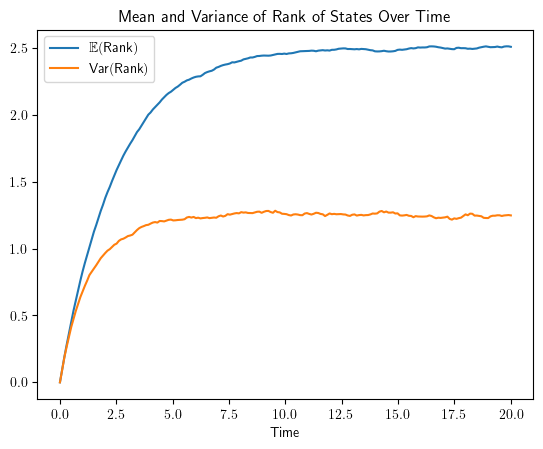

Final mean: 2.508 (relative error: 0.003)
Final var:  1.248 (relative error: -0.002)


In [4]:
means = np.mean(ranks, axis=0)
vars = np.var(ranks, axis=0)
plt.plot(ts, means, label=r"$\mathbb{E}(\text{Rank})$")
plt.plot(ts, vars, label=r"$\text{Var}(\text{Rank})$")
plt.xlabel("Time")
plt.title("Mean and Variance of Rank of States Over Time")
plt.legend()
plt.show()
print("Final mean: {:.3f} (relative error: {:.3f})".format(means[-1], (means[-1] - 2.5)/2.5))
print("Final var:  {:.3f} (relative error: {:.3f})".format(vars[-1], (vars[-1] - 5/4) / (5/4)))

The mean and variance of the rank appears to match the expected values of 5/2 and 5/4 after approximately 5 time units. The code below plots the actual initial and final distribution of the states.

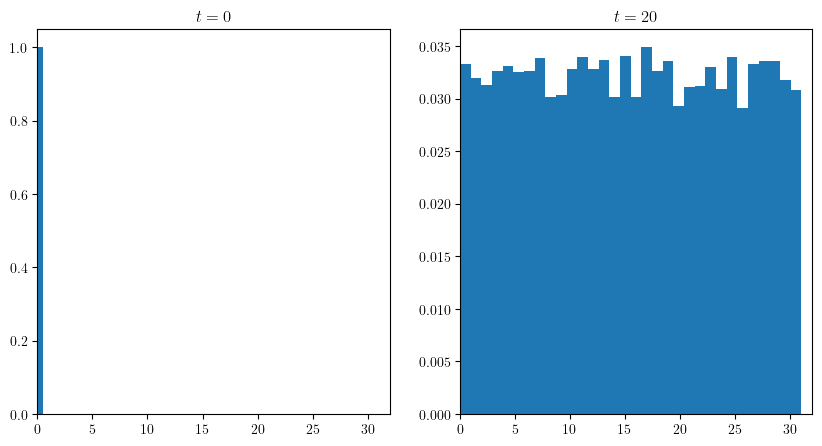

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(states[:, 0], density=True, bins=1)
ax[0].set_xlim(0, 32)
ax[0].set_title("$t = 0$")
ax[1].hist(states[:, -1], density=True, bins=32)
ax[1].set_xlim(0, 32)
ax[1].set_title("$t = 20$")
plt.show()

The code below animates the actual distribution of states over time.

In [8]:
fig, ax = plt.subplots()
def update(frame):
    ax.clear()
    ax.hist(states[:, frame], density=True, bins=32)
    ax.set_xlabel("State")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, 32)
    ax.set_title("$t = {:.2f}$".format(N_time_samples * 20/(frame+1)))
anim = animation.FuncAnimation(fig, update, N_time_samples, interval=20)
plt.close()
display(anim)

## Multivariate Normal Fitting

The code below generates $L$, $C$, and then 10,000 samples of a multivariate gaussian with $C$ as its covariance matrix.

In [10]:
d = 10
N = int(1e4)
L = np.zeros((d,d))
for i in range(d):
    for j in range(i+1):
        L[i,j] = 1/(i - j + 1)
L = np.array(L)
C = np.dot(L, L.T)
S = scipy.stats.multivariate_normal.rvs(np.zeros(d), C, size=N)

It seems to be more complicated than it should be to print these matrices without the line wrap occurring at the wrong place, so below I plot the matrices as heat maps.

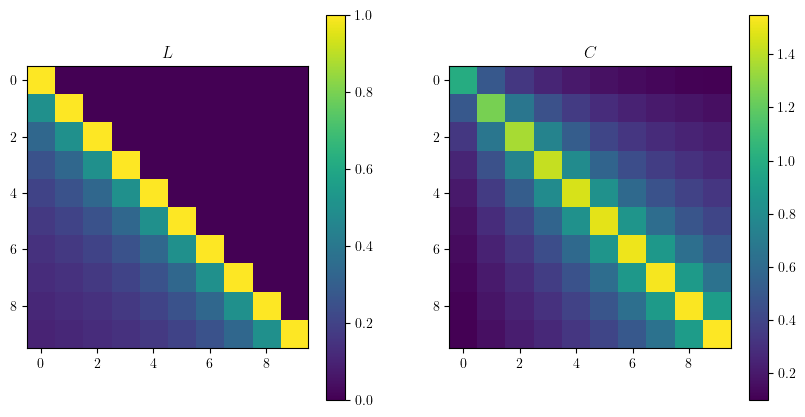

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(C)
ax[1].set_title("$C$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

The code below plots the marginal distributions for each dimension, and compares them to a normal distribution with the same mean and standard deviation. Each marginal is clearly quite normal.

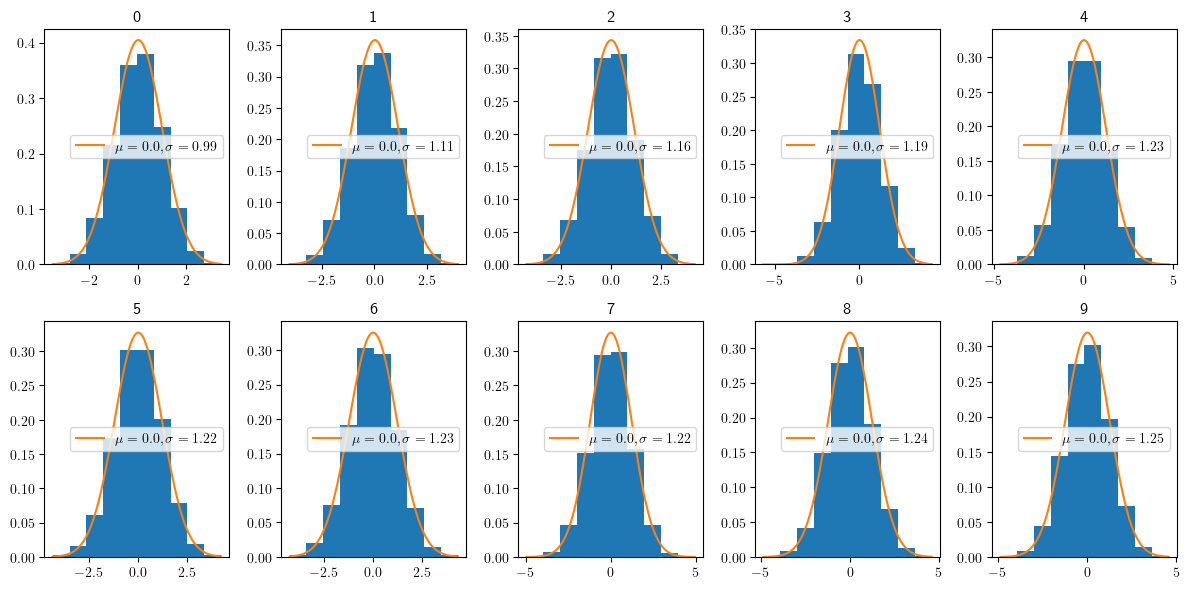

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    a = ax[i//5][i%5]
    data = S[:,i]
    data_min = data.min()
    data_max = data.max()
    data_mean = data.mean()
    data_std = data.std()
    xs = np.linspace(data_min, data_max, 100)
    a.hist(S[:,i], density=True)
    a.plot(xs, scipy.stats.norm.pdf(xs, data_mean, data_std), label="$\\mu = {:.1f}, \\sigma = {:.2f}$".format(data_mean, data_std))
    a.set_title("{}".format(i))
    a.legend()
fig.tight_layout()
plt.suptitle("")
plt.show()

The code below plots some example 2-variable marginals. They also appear quite normal.

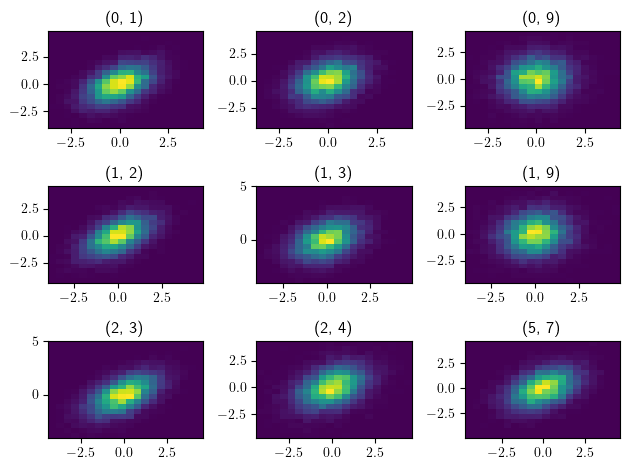

In [66]:
indices = [(0, 1), (0, 2), (0, 9), (1, 2), (1, 3), (1, 9), (2, 3), (2, 4), (5, 7)]
fig, ax = plt.subplots(3, 3)
for n,ind in enumerate(indices):
    a = ax[n//3][n%3]
    i,j = ind
    a.hist2d(S[:,i], S[:,j], bins=(20,20))
    a.set_title("({}, {})".format(i, j))
fig.tight_layout()
plt.show()

The code below estimates $L' \approx L$ by taking the cholesky decomposition of the sample covariance. The result is compared to the actual $L$, and is very close.

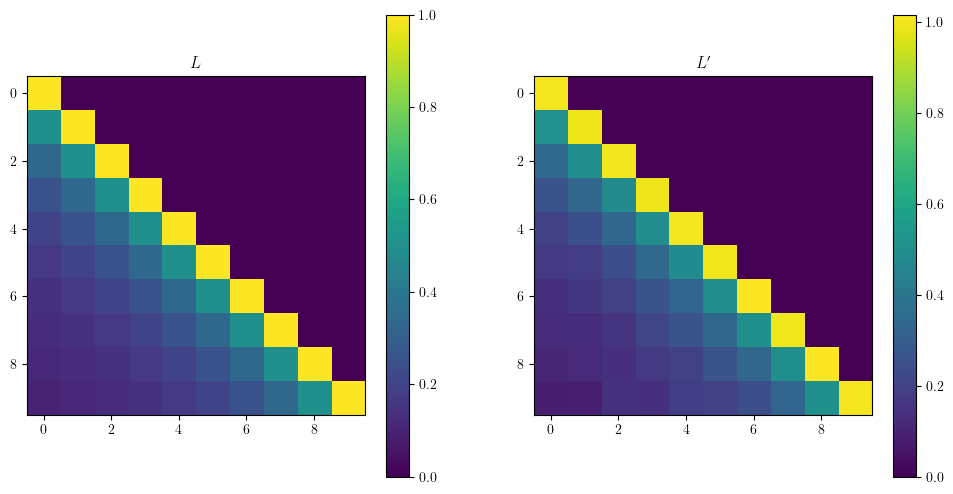

In [67]:
cov = np.cov(S.T)
L_prime = np.linalg.cholesky(cov)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data0 = ax[0].imshow(L)
ax[0].set_title("$L$")
data1 = ax[1].imshow(L_prime)
ax[1].set_title("$L'$")
fig.colorbar(data0, ax=ax[0])
fig.colorbar(data1, ax=ax[1])
plt.show()

The error is plotted below. The total mean square error is approximately 0.00005.

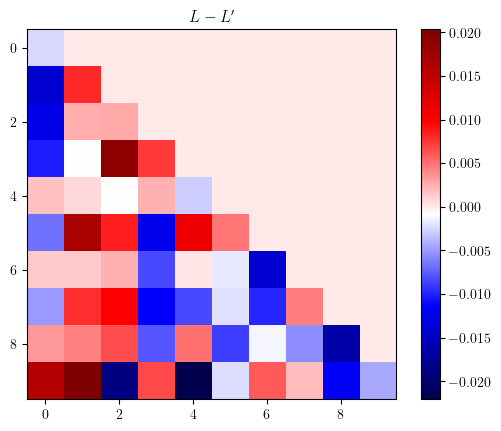

Error:  4.7757620549459586e-05


In [69]:
error = L-L_prime
plt.imshow(error, cmap=mpl.colormaps['seismic'])
plt.title("$L - L'$")
plt.colorbar()
plt.show()
error = (error**2).mean()
print("Error: ", error)